# Audioset demos

* The AudioSet Strong dataset https://research.google.com/audioset/download_strong.html has nice labels at a sub-second level of granularity.
* Need yt-dlp in use

In [1]:
%pip install --quiet yt-dlp 

# %pip install audioset-strong-download # Kinda sucks - If a file is associated to multiple labels, it will be stored multiple times.


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import torch
import IPython.display as ipd
import audio_classifier_visualizer as acv
from tqdm import tqdm

try:
    import cupy
    os.environ['SSQ_GPU'] = '1'
    print("If this works, cupy is working",cupy.arange(10))
except ImportError as e:
    if torch.cuda.is_available():
        print("For faster performance you may want to `pip install cupy-cuda12x`")

If this works, cupy is working [0 1 2 3 4 5 6 7 8 9]


In [3]:
ash = acv.AudioSetHelper(output_dir="data/audioset/opus")

In [4]:
ash.create_label_arrays('b0RFKhbpFJA_30000')

(['Wind',
  'Buzz',
  'Male speech, man speaking',
  'Tick',
  'Wind noise (microphone)'],
 tensor([[1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 0.0000, 0.0000, 

In [5]:
ash.ddb.sql(" select * from class_labels_indices")

┌───────┬────────────┬───────────────────────────────┐
│ index │    mid     │         display_name          │
│ int64 │  varchar   │            varchar            │
├───────┼────────────┼───────────────────────────────┤
│     0 │ /m/09x0r   │ Speech                        │
│     1 │ /m/05zppz  │ Male speech, man speaking     │
│     2 │ /m/02zsn   │ Female speech, woman speaking │
│     3 │ /m/0ytgt   │ Child speech, kid speaking    │
│     4 │ /m/01h8n0  │ Conversation                  │
│     5 │ /m/02qldy  │ Narration, monologue          │
│     6 │ /m/0261r1  │ Babbling                      │
│     7 │ /m/0brhx   │ Speech synthesizer            │
│     8 │ /m/07p6fty │ Shout                         │
│     9 │ /m/07q4ntr │ Bellow                        │
│     · │     ·      │   ·                           │
│     · │     ·      │   ·                           │
│     · │     ·      │   ·                           │
│   517 │ /m/0g12c5  │ Distortion                    │
│   518 │ 

In [6]:
ash.ddb.sql("select * from mid_to_display_name limit 3")

┌───────────────┬────────────────┐
│      mid      │  displayname   │
│    varchar    │    varchar     │
├───────────────┼────────────────┤
│ /g/11b630rrvh │ Kettle whistle │
│ /g/122z_qxw   │ Firecracker    │
│ /m/01280g     │ Wild animals   │
└───────────────┴────────────────┘

In [7]:
ash.ddb.sql("select * from audioset_train_strong limit 3")

┌───────────────────┬────────┬────────┬────────────┐
│      clip_id      │   st   │   et   │    mid     │
│      varchar      │ double │ double │  varchar   │
├───────────────────┼────────┼────────┼────────────┤
│ b0RFKhbpFJA_30000 │    0.0 │   10.0 │ /m/03m9d0z │
│ b0RFKhbpFJA_30000 │  4.753 │   5.72 │ /m/05zppz  │
│ b0RFKhbpFJA_30000 │    0.0 │   10.0 │ /m/07pjwq1 │
└───────────────────┴────────┴────────┴────────────┘

In [8]:
cat_labels = ash.ddb.sql("select * from mid_to_display_name where displayname in ('Cat','Caterwaul','Purr','Meow','Cat communication')")
dog_labels = ash.ddb.sql("select * from mid_to_display_name where displayname ilike '%dog%' or displayname ilike '%bark%' or displayname ilike '%yip%' ")

In [9]:
import pandas as pd

pd.set_option('display.max_colwidth', None)

ash.ddb.sql("""
    with cat_vids as (
            select distinct clip_id from audioset_train_strong where mid in (select distinct mid from cat_labels)
    ),
    dog_vids as (
            select distinct clip_id from audioset_train_strong where mid in (select distinct mid from dog_labels)
    )
    select count(distinct mid) num_labels, clip_id, array_agg(distinct displayname)
        from audioset_train_strong as ats
        join cat_vids using (clip_id)
        join dog_vids using (clip_id)
        join mid_to_display_name using (mid)
        group by clip_id
        order by num_labels desc
        limit 10
""").df()

,num_labels,clip_id,array_agg(DISTINCT displayname)
0,10,qUQD1mdcnNg_0,"[Clicking, Tick, Crowing, cock-a-doodle-doo, Moo, Neigh, whinny, Meow, Bleat, Bark, Breathing, Male speech, man speaking]"
1,10,0X5yGzLr7YA_30000,"[Conversation, Surface contact, Purr, Bird vocalization, bird call, bird song, Bark, Female speech, woman speaking, Generic impact sounds, Background noise, Breathing, Male speech, man speaking]"
2,10,0SEHGxAQL18_30000,"[Generic impact sounds, Wind, Human sounds, Bird vocalization, bird call, bird song, Meow, Bark, Conversation, Breathing, Male speech, man speaking, Female speech, woman speaking]"
3,9,kuoQtqGpsD0_120000,"[Human voice, Pant (dog), Dog, Generic impact sounds, Cat, Background noise, Bark, Tick, Female speech, woman speaking]"
4,9,Xpd1fE2bTA8_23000,"[Mechanisms, Bark, Male speech, man speaking, Human voice, Cat, Surface contact, Generic impact sounds, Tick, Tap]"
5,9,-CzAjJI8PbA_12000,"[Dog, Music, Cat, Breathing, Laughter, Male speech, man speaking, Mechanisms, Singing, Tick]"
6,9,f1Lakc8ktbg_170000,"[Generic impact sounds, Meow, Bark, Tick, Clicking, Background noise, Breathing, Laughter, Dog]"
7,9,03H8DdpF-dc_30000,"[Motor vehicle (road), Chirp, tweet, Generic impact sounds, Laughter, Male speech, man speaking, Meow, Bark, Wind, Accelerating, revving, vroom]"
8,9,0lFyoYjKqgA_30000,"[Generic impact sounds, Male speech, man speaking, Wind noise (microphone), Female speech, woman speaking, Meow, Mechanisms, Conversation, Dog, Bird vocalization, bird call, bird song]"
9,8,gS8bJzcHMcw_100000,"[Cat, Human voice, Female speech, woman speaking, Generic impact sounds, Surface contact, Child speech, kid speaking, Caterwaul, Bark]"


In [10]:
clip_id = 'kuoQtqGpsD0_120000'
print(ash.get_youtube_url(clip_id))
y,sr = ash.get_audio(clip_id)
y.shape,sr

https://www.youtube.com/watch?v=kuoQtqGpsD0&t=120.0s


((177496,), 16000)

In [11]:
# Audioset strong labels are at spacing of 960ms.


In [12]:
labels_for_a_clip = ash.ddb.execute(""" 
    select clip_id,st,et,mid,displayname
    from source_audioset_train_strong
    join mid_to_display_name using (mid)
    where clip_id = ?
    and displayname != 'Background noise'
    order by st
""",(clip_id,))

ash.ddb.sql(f""" 
    select clip_id,st,et,mid,displayname
    from source_audioset_train_strong
    join mid_to_display_name using (mid)
    where clip_id = '{clip_id}'
    and displayname != 'Background noise'
    order by st
""")

┌────────────────────┬────────┬────────┬────────────┬───────────────────────┐
│      clip_id       │   st   │   et   │    mid     │      displayname      │
│      varchar       │ double │ double │  varchar   │        varchar        │
├────────────────────┼────────┼────────┼────────────┼───────────────────────┤
│ kuoQtqGpsD0_120000 │    0.0 │  0.156 │ /m/0bt9lr  │ Dog                   │
│ kuoQtqGpsD0_120000 │  0.488 │  2.846 │ /m/01yrx   │ Cat                   │
│ kuoQtqGpsD0_120000 │  0.737 │  1.062 │ /t/dd00141 │ Pant (dog)            │
│ kuoQtqGpsD0_120000 │  1.269 │  1.539 │ /t/dd00141 │ Pant (dog)            │
│ kuoQtqGpsD0_120000 │  1.463 │  1.608 │ /t/dd00099 │ Generic impact sounds │
│ kuoQtqGpsD0_120000 │  1.705 │  1.961 │ /t/dd00141 │ Pant (dog)            │
│ kuoQtqGpsD0_120000 │  1.995 │  2.127 │ /t/dd00099 │ Generic impact sounds │
│ kuoQtqGpsD0_120000 │   2.12 │  2.327 │ /t/dd00141 │ Pant (dog)            │
│ kuoQtqGpsD0_120000 │  2.514 │  2.811 │ /t/dd00141 │ Pant (dog)

In [14]:
labels_for_a_clip = ash.ddb.execute(""" 
    select clip_id,st,et,mid,displayname as lbl
    from source_audioset_train_strong
    join mid_to_display_name using (mid)
    where clip_id = ?
    and displayname != 'Background noise'
    order by st
""",(clip_id,))
df = labels_for_a_clip.df()

In [15]:

l,v = ash.create_label_arrays(clip_id)


In [17]:
y.shape[0] /sr


11.0935

In [18]:
# v = torch.tensor([[1.0,0.0],[1.0,0.0]])
# l = [0,0]

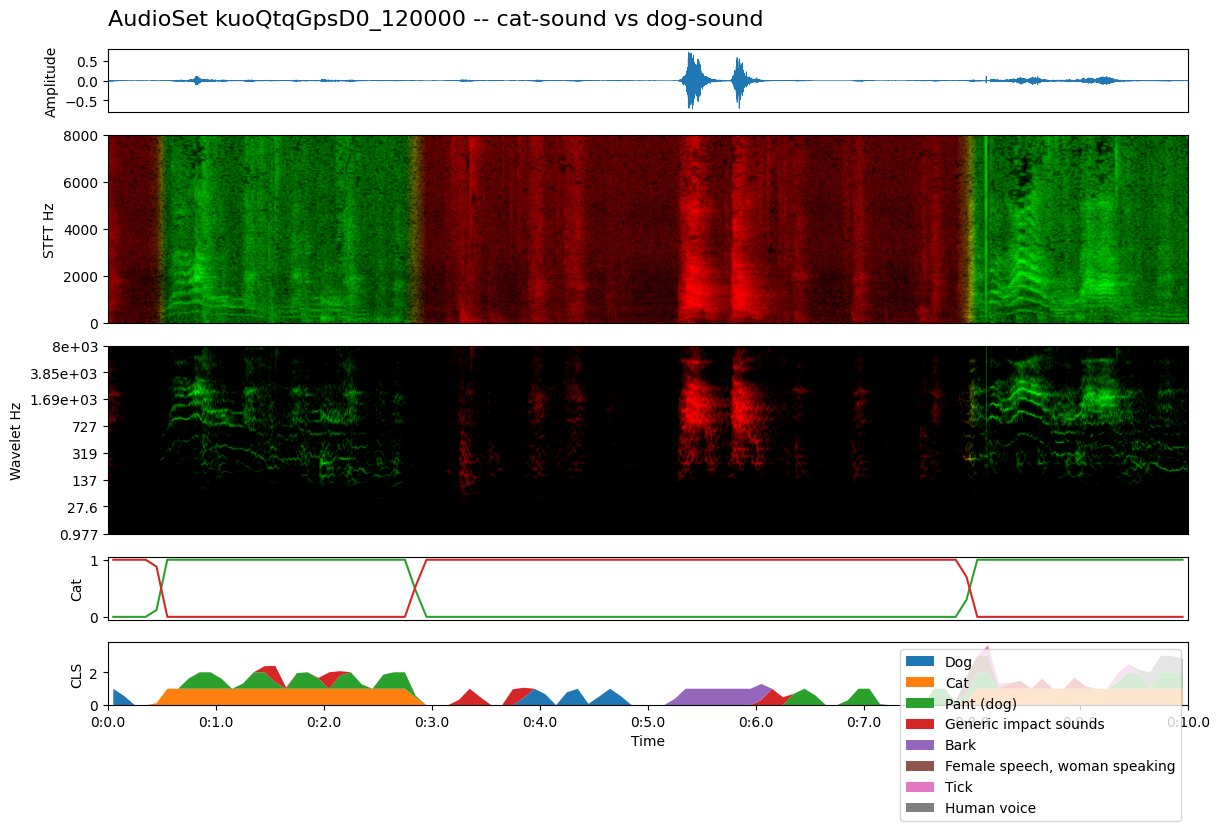

In [19]:
audio_file_processor = acv.AudioFileProcessor()
from audio_classifier_visualizer.audio_file_visualizer import Subplot

# TODO: There's a bug scaling the colors on the spectrograms when the duration of y is greater than the duration of the labels.

audio_file_visualizer = acv.AudioFileVisualizer(y=y[0:sr*10],
                                                sr=sr,
                                                start_time=0, 
                                                end_time=15,
                                                feature_rate=10,
                                                class_probabilities=v,
                                                n_fft=512,
                                                class_labels=l,
                                                #freq_range_of_interest=(100,12000)
                                                )


title = f"AudioSet {clip_id} -- cat-sound vs dog-sound"
audio_file_visualizer.visualize_audio_file_fragment(title, width=12, height=8).show()



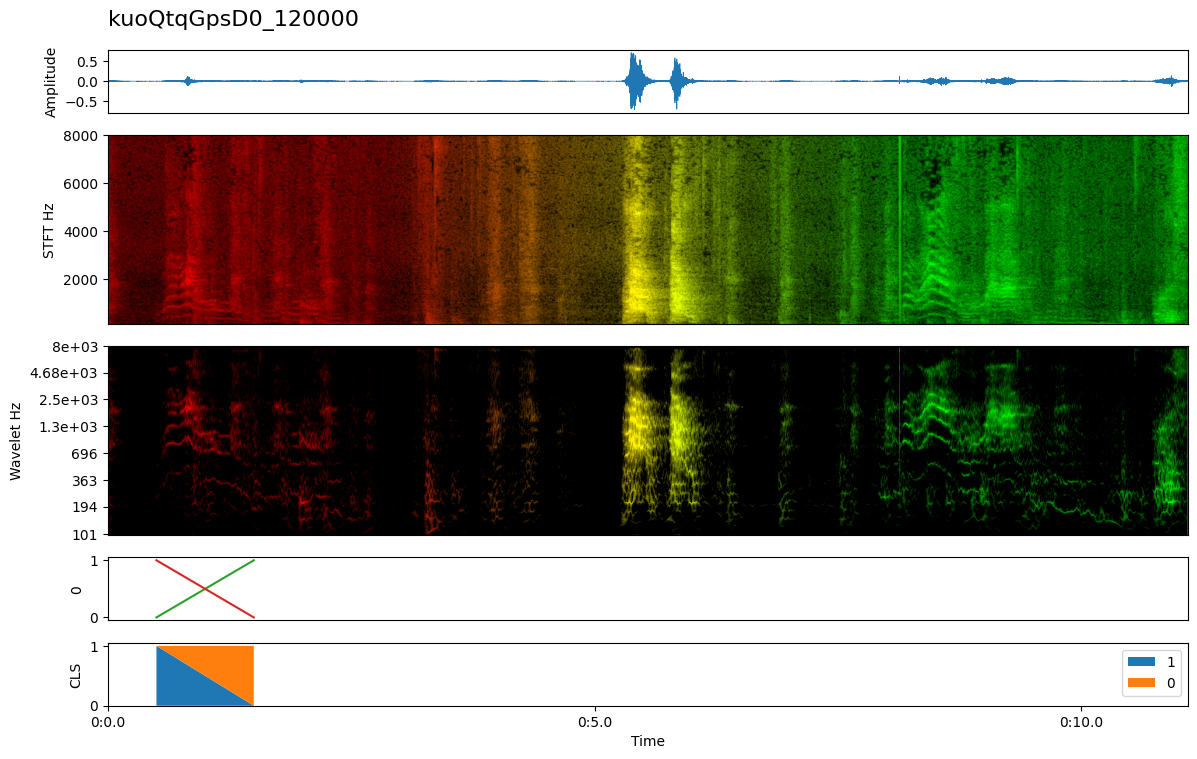